## Import requirements

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd

## Fetch data

In [0]:
from google.colab import drive

In [3]:
drive.mount("/google_drive")

Drive already mounted at /google_drive; to attempt to forcibly remount, call drive.mount("/google_drive", force_remount=True).


In [4]:
!ln -s /google_drive/My\ Drive/datasets ~/datasets
!ls ~/datasets

ln: failed to create symbolic link '/root/datasets/datasets': Function not implemented
digit-recognizer


train -> input: (25200, 784), label: (25200, 10)
validation -> input: (8400, 784), label: (8400, 10)
test -> input: (8400, 784), label: (8400, 10)


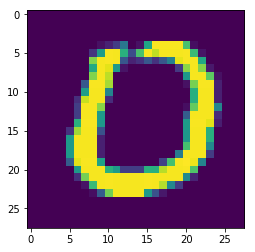

TRAIN_SIZE = 25200, BATCH_SIZE = 32, EPOCH = 16, TRAIN_STEPS = 787
epoch =  1, training accuracy = 0.921548
epoch =  2, training accuracy = 0.95004
epoch =  3, training accuracy = 0.960754
epoch =  4, training accuracy = 0.969524
epoch =  5, training accuracy = 0.977103
epoch =  6, training accuracy = 0.98246
epoch =  7, training accuracy = 0.986349
epoch =  8, training accuracy = 0.98881
+ epoch =  8, testing accuracy = 0.964643 +
epoch =  9, training accuracy = 0.990794
epoch = 10, training accuracy = 0.994127
epoch = 11, training accuracy = 0.995397
epoch = 12, training accuracy = 0.996825
epoch = 13, training accuracy = 0.997302
epoch = 14, training accuracy = 0.998175
epoch = 15, training accuracy = 0.998214
epoch = 16, training accuracy = 0.999524
+ epoch = 16, testing accuracy = 0.97131 +


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data_file = "~/datasets/digit-recognizer/train.csv"
kaggle_submit_data_file = "~/datasets/digit-recognizer/test.csv"

raw_dataset = pd.read_csv(train_data_file, sep=",").values
raw_kaggle_submit_dataset = pd.read_csv(kaggle_submit_data_file, sep=",").values

total_size = raw_dataset.shape[0]
split_point = [total_size * 6 // 10, total_size * 8 // 10]

raw_train_dataset = raw_dataset[: split_point[0]]
raw_validate_dataset = raw_dataset[split_point[0]: split_point[1]]
raw_test_dataset = raw_dataset[split_point[1]:]


def dense2one_hot(label_dense: np.ndarray, classes_count: int) -> np.ndarray:
    num_label = label_dense.shape[0]
    index_offset = np.arange(num_label) * classes_count
    label_one_hot = np.zeros(shape=[num_label, classes_count], dtype=np.int)
    label_one_hot.flat[index_offset + label_dense.ravel()] = 1
    return label_one_hot


def parse_dataset(dataset: np.ndarray) -> (np.ndarray, np.ndarray):
    label = dataset[:, : 1].astype(np.int)
    classes_count = np.unique(label).shape[0]
    return dataset[:, 1:].astype(np.float32) / 255.0, dense2one_hot(label, classes_count).astype(np.float32)


datasets = {
    "train": {},
    "validation": {},
    "test": {}
}

datasets["train"]["input"], datasets["train"]["label"] = parse_dataset(raw_train_dataset)
datasets["validation"]["input"], datasets["validation"]["label"] = parse_dataset(raw_validate_dataset)
datasets["test"]["input"], datasets["test"]["label"] = parse_dataset(raw_test_dataset)

for key in ["train", "validation", "test"]:
    print("{} -> input: {}, label: {}".format(key, datasets[key]["input"].shape, datasets[key]["label"].shape))


def plot_digit(pixels):
    plt.imshow(pixels.reshape(28, 28))
    plt.show()


plot_digit(datasets["test"]["input"][0, :])

layer_information = {
    "fc_0": {
        "weight": {
            "shape": [784, 1024],
            "initializer": tf.truncated_normal_initializer(stddev=0.1),
            "dtype": tf.float32
        },
        "bias": {
            "shape": [1024],
            "initializer": tf.constant_initializer(value=0.1),
            "dtype": tf.float32
        },
        "activation": tf.nn.relu
    },
    "fc_1": {
        "weight": {
            "shape": [1024, 10],
            "initializer": tf.truncated_normal_initializer(stddev=0.1),
            "dtype": tf.float32
        },
        "bias": {
            "shape": [10],
            "initializer": tf.constant_initializer(value=0.1),
            "dtype": tf.float32
        },
        "activation": tf.nn.softmax
    }
}

with tf.Graph().as_default():
    INPUT = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    LABEL = tf.placeholder(dtype=tf.float32, shape=[None, 10])

    previous_output = INPUT

    for namespace in layer_information:
        layer = layer_information[namespace]
        with tf.variable_scope(namespace, reuse=tf.AUTO_REUSE):
            weight = tf.get_variable("weight",
                                     shape=layer["weight"]["shape"],
                                     initializer=layer["weight"]["initializer"],
                                     dtype=layer["weight"]["dtype"])
            bias = tf.get_variable("bias",
                                   shape=layer["bias"]["shape"],
                                   initializer=layer["bias"]["initializer"],
                                   dtype=layer["bias"]["dtype"])
            previous_output = layer["activation"](tf.add(tf.matmul(previous_output, weight), bias))

    cross_entropy = -tf.reduce_sum(LABEL * tf.log(previous_output))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(previous_output, 1), tf.argmax(LABEL, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    TRAIN_SIZE = datasets['train']['input'].shape[0]
    BATCH_SIZE = 32
    EPOCH = 16
    TRAIN_STEPS = TRAIN_SIZE // BATCH_SIZE

    print("TRAIN_SIZE = {}, BATCH_SIZE = {}, EPOCH = {}, TRAIN_STEPS = {}".
          format(TRAIN_SIZE, BATCH_SIZE, EPOCH, TRAIN_STEPS))

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.graph.finalize()
        summary_writer = tf.compat.v1.summary.FileWriter("./log/", session.graph)

        for i in range(EPOCH):
            np.random.shuffle(raw_train_dataset)
            input_data, label_data = parse_dataset(raw_train_dataset)

            for j in range(TRAIN_STEPS):
                lower = j * BATCH_SIZE
                upper = (j + 1) * BATCH_SIZE
                batch_input = input_data[lower: upper]
                batch_label = label_data[lower: upper]

                session.run(train_step, {
                    INPUT: batch_input,
                    LABEL: batch_label
                })

            print("epoch = %2d, training accuracy = %g" % (i + 1, session.run(accuracy, {
                INPUT: input_data,
                LABEL: label_data
            })))

            if (i + 1) % 8 == 0:
                print("+ epoch = %2d, testing accuracy = %g +" % (i + 1, session.run(accuracy, {
                    INPUT: datasets["test"]["input"],
                    LABEL: datasets["test"]["label"]
                })))
